# Datenanalyse der Brettspielwelt-DB

## 3. ScoreCum skalieren

Der kumulative Score ist ein nummerischer kontinuierlicher Wert.

**Theoretischer Bereich:** [-INF, 995]

**Datenmenge:** 44.000.296 Werte (2 * 22.000.148 Runden der fehlerfreien Partien)

**Analyseergebnis**

*  **Clipping**:

*  **Skalierungsstrategie**:



### 3.1 Daten abfragen

In [49]:
%%sql
select r.score_cum_20 as score_cum
from rounds as r
inner join games as g on r.game_id = g.id
where g.error_code = 0
union all
select score_cum_31 as score_cum
from rounds as r
inner join games as g on r.game_id = g.id
where g.error_code = 0


,score_cum
0,0
1,25
2,220
3,520
4,685
...,...
44000291,305
44000292,330
44000293,245
44000294,305


### 3.2 Histogramm (Verteilungsdiagramm)

Ein Histogramm zeigt die Häufigkeit von Werten in einem Datensatz – also wie oft Werte in bestimmten Intervallen (Bins) vorkommen.

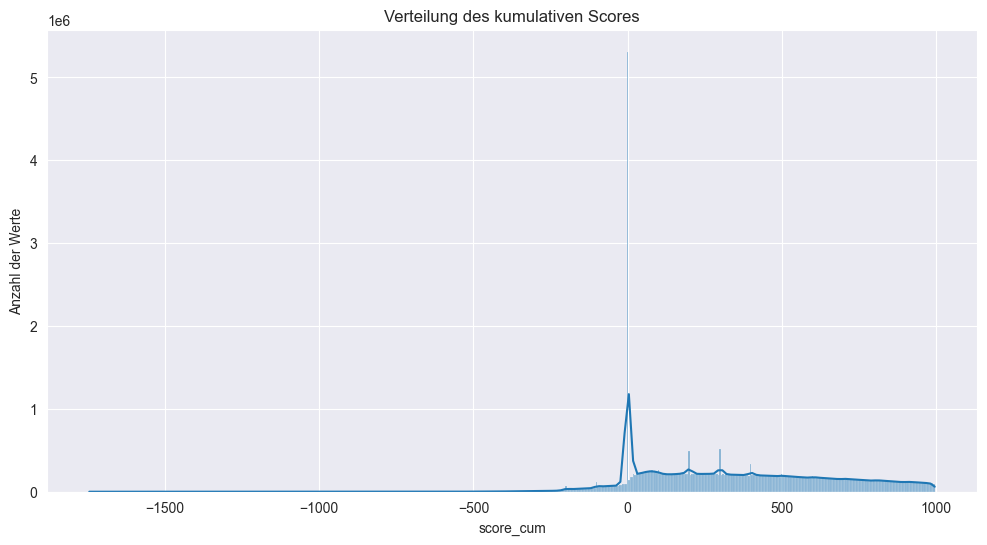

In [78]:
# Histogramms für den kumulativen Score
# bins = max_cum/5 - min_cum/5 + 1 = 995/5 - -1745/5 + 1 = 549

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df1['score_cum'], bins=549, kde=True)
plt.title('Verteilung des kumulativen Scores')
plt.xlabel('score_cum')
plt.ylabel('Anzahl der Werte')
plt.grid(True)
plt.show()

**Interpretation des Histogramms:**

* **Keine Symmetrie:** Im Gegensatz zu den Runden-Scores (die um 0 zentriert waren), sind die kumulativen Partie-Scores es nicht. Das ist logisch, da Teams Punkte sammeln und sich vom Nullpunkt wegbewegen.
* **"Rennen zum Ziel":** Die meisten Spielzustände treten auf, wenn Teams bereits einen signifikanten Punktestand haben und sich der 1000-Punkte-Grenze nähern. Zustände am Anfang einer Partie (Score nahe 0) sind seltener als Zustände in der Mitte oder am Ende.
* **Langer Verlust-Schwanz:** Es ist seltener, einen stark negativen Gesamtpunktestand zu haben, aber es kommt vor (daher der lange Schwanz nach links).
* **Die kleinen "Beulen":** Die wellenartige Struktur im positiven Bereich spiegelt wieder die diskreten Punktesprünge wider (Runden enden oft mit Scores um 100, 200 etc.).

### 3.3 Neues Feature "Zieldistanz"

Die Distanz zu 1000 ist die wichtigste Information bzgl. des kumulativen Scores! Ein Punktestand von 950 ist strategisch völlig anders als ein Punktestand von 850, obwohl der Unterschied nur 100 Punkte beträgt. Ein Punktestand von 200 vs. 300 ist hingegen strategisch fast identisch.

Die **Zieldistanz** wird als neues Feature eingeführt (0 == Ziel erreicht oder überschritten):
* `points_to_win_20 = max(0, 1000 - score_cum_20)`
* `points_to_win_31 = max(0, 1000 - score_cum_31)`

Das Feature beantwortet direkt die Frage, die ein menschlicher Spieler sich stellt: "Wie viele Punkte fehlen mir noch?" und "Wie viele Punkte fehlen dem Gegner noch?"
Das Netz muss nicht mehr selbst lernen, dass 950 bedeutet, dass 50 Punkte fehlen, sondern es bekommt die 50 direkt als Input. Das kann das Lernen erheblich beschleunigen und zu besseren Entscheidungen führen.

**Frage:** Bringt es was, dem Netz beides zu geben: `score_cum` UND `points_to_win`?

Dem Netz beides zu geben, kann sehr vorteilhaft sein und ist eine gängige Praxis im fortgeschrittenen Feature Engineering. Auf den ersten Blick scheint es redundant, aber es ist eine sinnvolle Redundanz. Manchmal kann es für ein Netz einfacher sein, eine Regel basierend auf dem absoluten Wert zu lernen, und manchmal basierend auf der Distanz.

Weil `score_cum` max. 995 sein kann (bei fehlerfreien Partien), gilt:
* Theoretische Bereich für `points_to_win`: [5, INF]


In [57]:
# Berechne die Zieldistanz
df1['points_to_win'] = df1['score_cum'].apply(lambda x: max(0, 1000 - x))
df1['points_to_win']

0           1000
1            975
2            780
3            480
4            315
            ... 
44000291     695
44000292     670
44000293     755
44000294     695
44000295     695
Name: points_to_win, Length: 44000296, dtype: int64

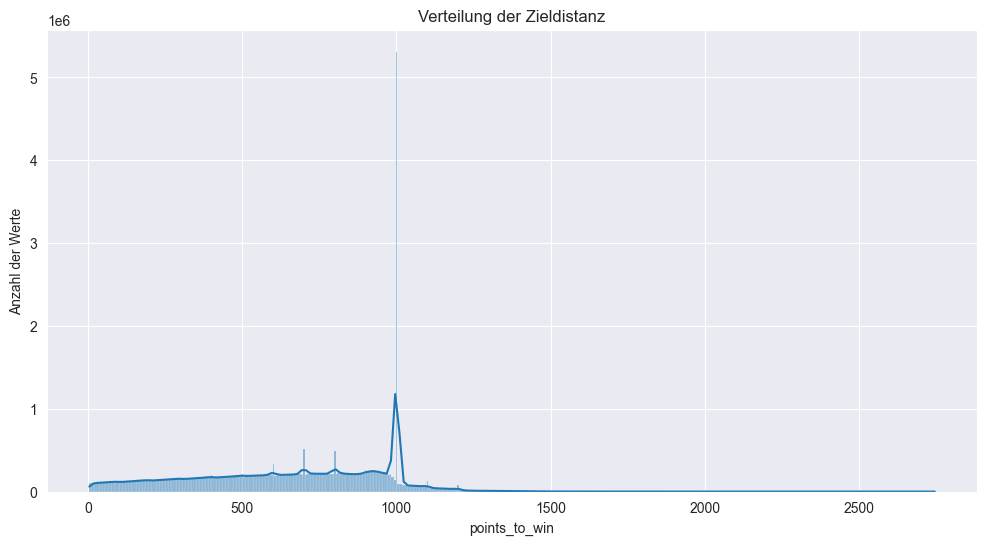

In [77]:
# Histogramms für die Zieldistanz
# bins = max_ptw/5 - min_ptw/5 + 1 = 2745/5 - 5/5 + 1 = 549

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df1['points_to_win'], bins=549, kde=True)
plt.title('Verteilung der Zieldistanz')
plt.xlabel('points_to_win')
plt.ylabel('Anzahl der Werte')
plt.grid(True)
plt.show()

1**Interpretation:**

* **Gipfel bei 1000:** Der riesige Balken bei 1000 repräsentiert den Anfang jeder einzelnen Partie. Zu Beginn einer Partie (Score = 0) fehlen jedem Team exakt 1000 Punkte zum Sieg. Da jede Partie diesen Zustand durchläuft, ist er extrem häufig.
* **Der "Hügel" (< 1000>):** Dies ist der interessanteste Teil. Es zeigt die Verteilung der "Distanz zum Ziel" während des Spielverlaufs.
* **Langer Schwanz (> 1000):** Der lange Schwanz nach rechts repräsentiert die Situationen, in denen ein Team einen negativen Gesamtpunktestand hat. Wenn ein Team bei -200 Punkten steht, fehlen ihm 1000 - (-200) = 1200 Punkte zum Sieg. Diese Fälle sind seltener, daher der abfallende Schwanz.

### 3.3 Statistischen Kennzahlen

#### 3.3.1 Kennzahlen für den kumulativen Score

In [59]:
# Berechne die wichtigsten statistischen Kennzahlen für den kumulativen Score

#import pandas as pd
#import numpy as np

stats_cum = df1['score_cum'].describe(percentiles=[0.005, .01, .05, .95, .99, .995])
count = stats_cum['count']
mean_cum = stats_cum['mean']
stdev_cum = stats_cum['std'] # .std() in Pandas verwendet standardmäßig ddof=1 (Stichprobe)
min_cum = stats_cum['min']
max_cum = stats_cum['max']
p005_cum = stats_cum['0.5%']
p995_cum = stats_cum['99.5%']
p01_cum = stats_cum['1%']
p99_cum = stats_cum['99%']
p05_cum = stats_cum['5%']
p95_cum = stats_cum['95%']

print(f"Anzahl der Werte der fehlerfreien Partien: {count:.0f}")

print("\n-- Kumulativer Score: --")
print(f"Mittelwert: {mean_cum:.2f} ± {stdev_cum:.2f}")
print(f"Bereich: [{min_cum:.0f}, {max_cum:.0f}]")
print(f"99% aller Werte liegen zwischen {p005_cum:.0f} und {p995_cum:.0f}.")
print(f"98% aller Werte liegen zwischen {p01_cum:.0f} und {p99_cum:.0f}.")
print(f"90% aller Werte liegen zwischen {p05_cum:.0f} und {p95_cum:.0f}.")
# Gibt es Ausreißer in total_score?
has_outliers = (min_cum < p005_cum - stdev_cum) or (max_cum > p995_cum + stdev_cum)
if has_outliers:
    print("Es gibt signifikante Ausreißer.")
else:
    print("Die Datenverteilung hat keine extremen Ausreißer.")

Anzahl der Werte der fehlerfreien Partien: 44000296

-- Kumulativer Score: --
Mittelwert: 350.47 ± 310.30
Bereich: [-1745, 995]
99% aller Werte liegen zwischen -285 und 985.
98% aller Werte liegen zwischen -200 und 975.
90% aller Werte liegen zwischen -30 und 900.
Es gibt signifikante Ausreißer.


#### 3.3.2 Kennzahlen für die Zieldistanz

In [60]:
# Berechne die wichtigsten statistischen Kennzahlen für die Zieldistanz

stats_ptw = df1['points_to_win'].describe(percentiles=[0.005, .01, .05, .95, .99, .995])
mean_ptw = stats_ptw['mean']
stdev_ptw = stats_ptw['std']
min_ptw = stats_ptw['min']
max_ptw = stats_ptw['max']
p005_ptw = stats_ptw['0.5%']
p995_ptw = stats_ptw['99.5%']
p01_ptw = stats_ptw['1%']
p99_ptw = stats_ptw['99%']
p05_ptw = stats_ptw['5%']
p95_ptw = stats_ptw['95%']

print("\n-- Zieldistanz: --")
print(f"Mittelwert: {mean_ptw:.2f} ± {stdev_ptw:.2f}")
print(f"Bereich: [{min_ptw:.0f}, {max_ptw:.0f}]")
print(f"99% aller Werte liegen zwischen {p005_ptw:.0f} und {p995_ptw:.0f}.")
print(f"98% aller Werte liegen zwischen {p01_ptw:.0f} und {p99_ptw:.0f}.")
print(f"90% aller Werte liegen zwischen {p05_ptw:.0f} und {p95_ptw:.0f}.")
# Gibt es Ausreißer in points_to_win?
has_outliers = (min_ptw < p005_ptw - stdev_ptw) or (max_ptw > p995_ptw + stdev_ptw)
if has_outliers:
    print("Es gibt signifikante Ausreißer.")
else:
    print("Die Datenverteilung hat keine extremen Ausreißer.")


-- Zieldistanz: --
Mittelwert: 649.53 ± 310.30
Bereich: [5, 2745]
99% aller Werte liegen zwischen 15 und 1285.
98% aller Werte liegen zwischen 25 und 1200.
90% aller Werte liegen zwischen 100 und 1030.
Es gibt signifikante Ausreißer.


### 3.4 Clipping

Ziel: Extreme, seltene und potenziell fehlerhafte Werte abschneiden, die die Statistik verzerren.


#### 3.4.1 Clipping für den kumulativen Score

Der Perzentil-Ansatz ist hier perfekt:
* Bereich: [-1745, 995]
* 99% aller Werte liegen zwischen -285 und 985.
* 98% aller Werte liegen zwischen -200 und 975.

Ich wähle den Bereich [-250, 995]

In [87]:
# Clipping des kumulativen Scores

# SQL-Syntax: WHERE score BETWEEN 250 AND 995
df1['score_cum_clipped'] = df1['score_cum'].clip(lower=-250, upper=995)

# Kennzahlen nach dem Clipping
stats_cum = df1['score_cum_clipped'].describe()
mean_cum = stats_cum['mean']
stdev_cum = stats_cum['std'] # .std() in Pandas verwendet standardmäßig ddof=1 (Stichprobe)
min_cum = stats_cum['min']
max_cum = stats_cum['max']
print(f"Mittelwert: {mean_cum:.2f}")
print(f"Standardabweichung: {stdev_cum:.2f}")
print(f"Bereich: [{min_cum:.0f}, {max_cum:.0f}]")

Mittelwert: 351.26
Standardabweichung: 308.43
Bereich: [-250, 995]


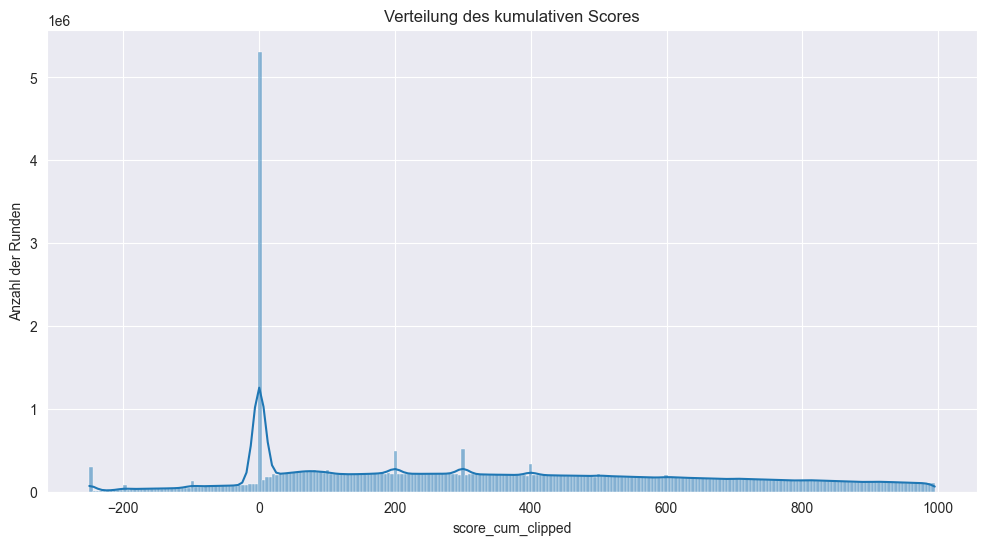

In [76]:
# Histogram für den kumulativen Scores
# bins = max_cum/5 - min_cum/5 + 1 = 995/5 - -250/5 + 1 = 250

plt.figure(figsize=(12, 6))
sns.histplot(data=df1, x='score_cum_clipped', bins=250, kde=True)
plt.title('Verteilung des kumulativen Scores')
plt.xlabel("score_cum_clipped")
plt.ylabel('Anzahl der Runden')
plt.grid(True)
plt.show()

#### 3.4.2 Clipping für die Zieldistanz

Aus dem gewählten kumulativen Score-Bereich [-250, 995] lässt sich mit `1000 - score_cum` der Bereich für die Zieldistanz berechnen: [5, 1250]

Damit treffen wir die gleichen Perzentile:
* 99% aller Werte liegen zwischen 15 und 1285.
* 98% aller Werte liegen zwischen 25 und 1200.

In [71]:
# Clipping für die Zieldistanz

# SQL-Syntax: WHERE score BETWEEN 250 AND 995
df1['points_to_win_clipped'] = df1['points_to_win'].clip(lower=-5, upper=1250)

# Kennzahlen nach dem Clipping
stats_ptw = df1['points_to_win_clipped'].describe()
mean_ptw = stats_ptw['mean']
stdev_ptw = stats_ptw['std'] # .std() in Pandas verwendet standardmäßig ddof=1 (Stichprobe)
min_ptw = stats_ptw['min']
max_ptw = stats_ptw['max']
print(f"Mittelwert: {mean_ptw:.2f}")
print(f"Standardabweichung: {stdev_ptw:.2f}")
print(f"Bereich: [{min_ptw:.0f}, {max_ptw:.0f}]")

Mittelwert: 648.74
Standardabweichung: 308.43
Bereich: [5, 1250]


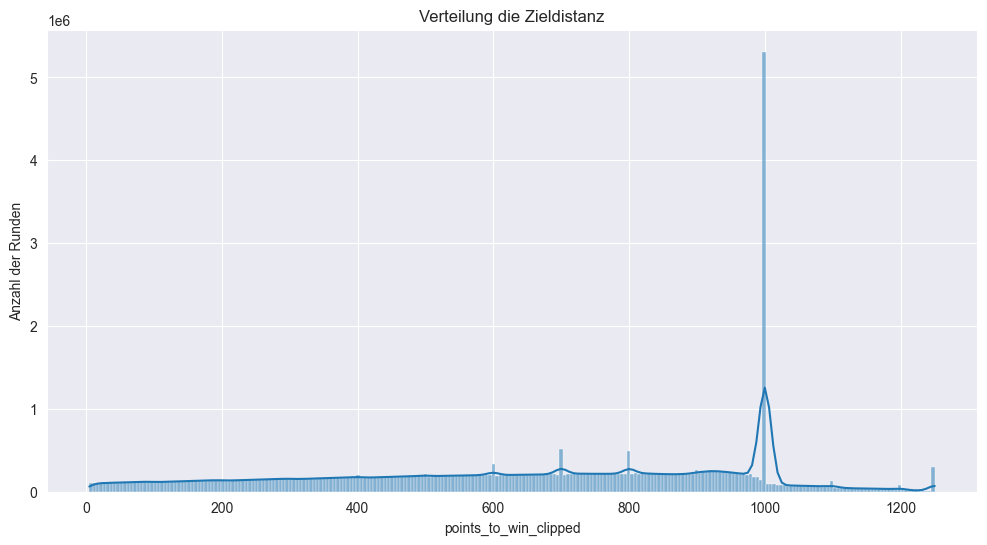

In [74]:
# Histogram für die Zieldistanz
# bins = max_ptw/5 - min_ptw/5 + 1 = 1250/5 - 5/5 + 1 = 250

plt.figure(figsize=(12, 6))
sns.histplot(data=df1, x='points_to_win_clipped', bins=250, kde=True)
plt.title('Verteilung die Zieldistanz')
plt.xlabel("points_to_win_clipped")
plt.ylabel('Anzahl der Runden')
plt.grid(True)
plt.show()

### 3.5 Skalierung

Ziel: Werte in einem kleinen Bereich um 0 transformieren, typischerweise [-1, 1] oder [0, 1]. 0, -1 oder 1 ist dabei der Bezugspunkt der Skala.

#### 3.5.1 Skalierung des kumulativen Scores

Die 1000-Punkte-Grenze ist für `score_cum` der Bezug. Je näher die Punkte an dieser Grenze sind, desto wichtiger sind sie. **WICHITG:** Dieser Zusammenhang (Wichtigkeit zu Abstand) ist NICHT linear!
* Bei der Standardisierung (Z-Score) ist der Durchschnittswert der Bezugspunkt, daher bietet sich diese Skalierung hier nicht an. Das Histogramm macht das deutlich: Wert 0 steht im wahrsten Sinne im Mittelpunkt, doch dieser Punkt ist nichts Besonderes!
* Bei der Normalisierung können wir die 1000-Grenze als Bezugspunkt beibehalten. Besser als Z-Score, doch leider ist die Zahlenleiste weiterhin linear.

Lösung: **Logarithmische Transformation `log(x)`.

Sie macht die Verteilung "normaler": Eine stark schiefe Verteilung wird durch die Log-Transformation oft in eine Form gebracht, die eine Glockenkurve viel ähnlicher sieht. Das ist für viele statistische Modelle und neuronale Netze ein idealer Zustand.

Wir verwenden `log(1 + x)` (oder `np.log1p(x)`, bekannt als "log plus one"), um das Problem mit `log(0)` zu umgehen.

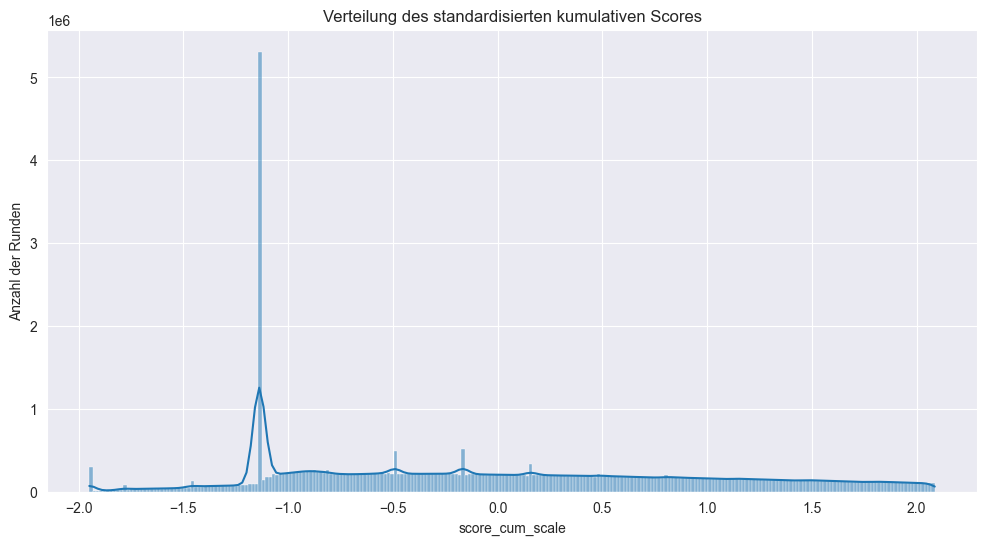

In [82]:
# Standardisierung des kumulativen Scores
# SQL-Syntax: (score - avg) / stddev

stats_cum = df1['score_cum_clipped'].describe()
df1['score_cum_scale'] = (df1['score_cum_clipped'] - stats_cum['mean']) / stats_cum['std']

# Kennzahlen der standardisierten Werte
stats_cum = df1['score_cum_scale'].describe()
print(f"Mittelwert (sollte ~0 sein): {stats_cum['mean']:.6f}")
print(f"Standardabweichung (sollte ~1 sein): {stats_cum['std']:.6f}")
print(f"Bereich: [{stats_cum['min']:.2f}, {stats_cum['max']:.2f}]")

# Histogramm
plt.figure(figsize=(12, 6))
sns.histplot(data=df1, x='score_cum_scale', bins=250, kde=True)
plt.title('Verteilung des standardisierten kumulativen Scores')
plt.xlabel('score_cum_scale')
plt.ylabel('Anzahl der Runden')
plt.grid(True)
plt.show()

Mittelwert (sollte ~0 sein): 0.482941
Standardabweichung (sollte ~1 sein): 0.247739
Bereich: [0.00, 1.00]


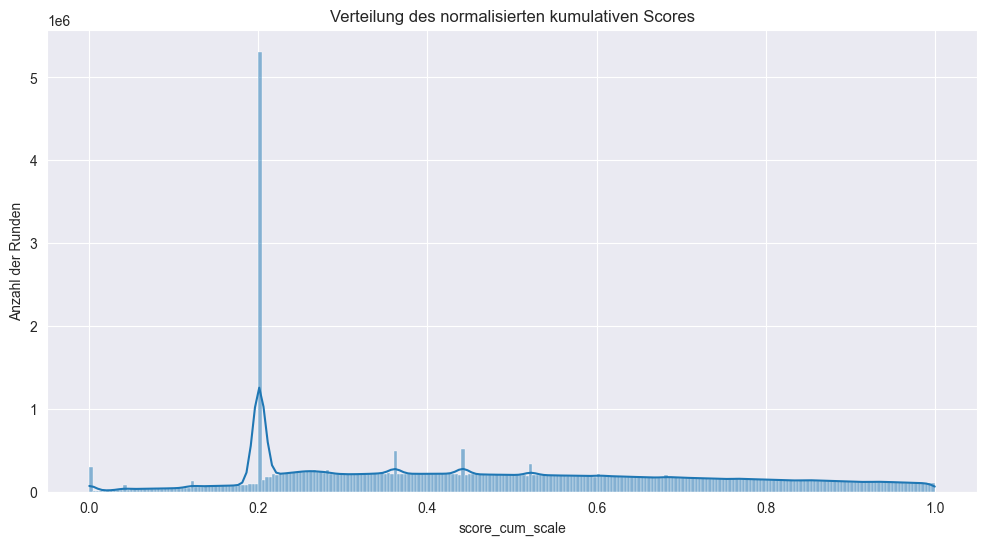

In [88]:
# Normalisierung des kumulativen Scores
# SQL-Syntax: (score - min_crm) / (max_max - min_cum)

stats_cum = df1['score_cum_clipped'].describe()
df1['score_cum_scale'] = (df1['score_cum_clipped'] - min_cum) / (max_cum - min_cum)

# Kennzahlen der standardisierten Werte
stats_cum = df1['score_cum_scale'].describe()
print(f"Mittelwert: {stats_cum['mean']:.6f}")
print(f"Standardabweichung: {stats_cum['std']:.6f}")
print(f"Bereich (sollte [0, 1] sein): [{stats_cum['min']:.2f}, {stats_cum['max']:.2f}]")

# Histogramm
plt.figure(figsize=(12, 6))
sns.histplot(data=df1, x='score_cum_scale', bins=250, kde=True)
plt.title('Verteilung des normalisierten kumulativen Scores')
plt.xlabel('score_cum_scale')
plt.ylabel('Anzahl der Runden')
plt.grid(True)
plt.show()

Mittelwert: 6.212944
Standardabweichung: 0.782544
Bereich: [0.00, 7.13]


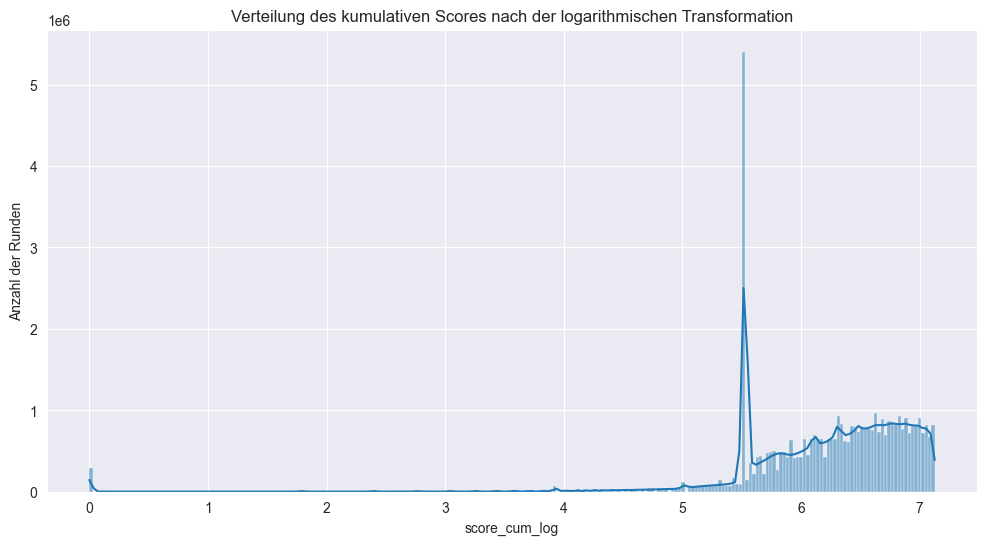

In [91]:
# Logarithmische Transformation des kumulativen Scores
# SQL-Syntax: log(1 + score_cum_clipped - min_cum)

import numpy as np

df1['score_cum_log'] = np.log1p(df1['score_cum_clipped'] - min_cum)

# Kennzahlen des Scores nach der logarithmischen Transformation
stats_cum = df1['score_cum_log'].describe()
print(f"Mittelwert: {stats_cum['mean']:.6f}")
print(f"Standardabweichung: {stats_cum['std']:.6f}")
print(f"Bereich: [{stats_cum['min']:.2f}, {stats_cum['max']:.2f}]")

# Histogramm
plt.figure(figsize=(12, 6))
sns.histplot(data=df1, x='score_cum_log', bins=250, kde=True)
plt.title('Verteilung des kumulativen Scores nach der logarithmischen Transformation')
plt.xlabel('score_cum_log')
plt.ylabel('Anzahl der Runden')
plt.grid(True)
plt.show()

In [99]:
np.log(1), np.log(1 + max_cum - min_cum),

(np.float64(0.0), np.float64(7.1276936993473985))

In [94]:
np.log1p(max_cum-min_cum)

np.float64(7.1276936993473985)

#### 3.5.2 Skalierung der Zieldistanz

Wende die Z-Score-Skalierung auf die logarithmierten Werte an.

In [83]:
# Standardisierung der Zieldistanz
# SQL-Syntax: (score - avg) / stddev

stats_ptw = df1['points_to_win_clipped'].describe()
df1['points_to_win_scale'] = (df1['points_to_win_clipped'] - stats_ptw['mean']) / stats_ptw['std']

# Kennzahlen der standardisierten Werte
stats_ptw = df1['points_to_win_scale'].describe()
print(f"Mittelwert (sollte ~0 sein): {stats_ptw['mean']:.6f}")
print(f"Standardabweichung (sollte ~1 sein): {stats_ptw['std']:.6f}")
print(f"Bereich: [{stats_ptw['min']:.2f}, {stats_ptw['max']:.2f}]")

Mittelwert (sollte ~0 sein): 0.000000
Standardabweichung (sollte ~1 sein): 1.000000
Bereich: [-2.09, 1.95]


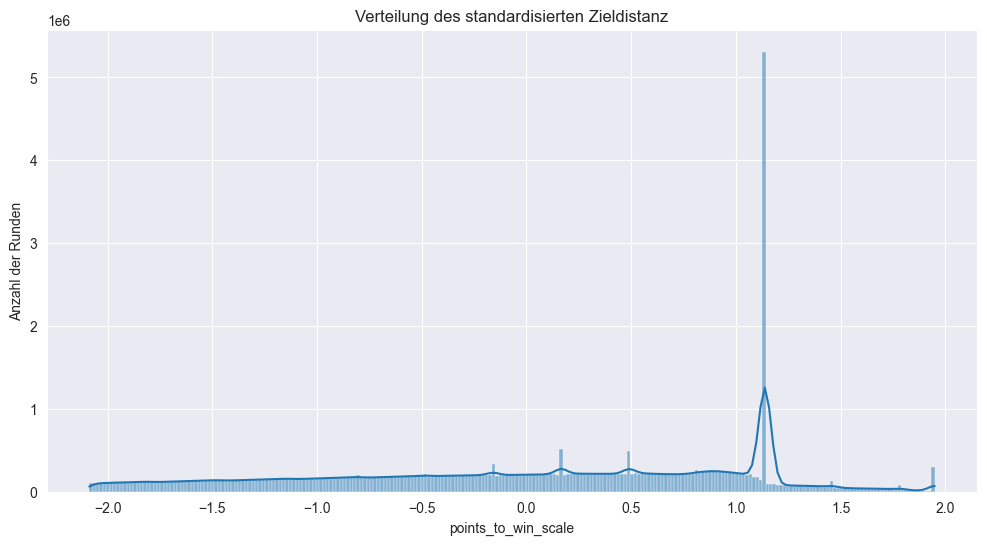

In [84]:
# Verteilung visualisieren
plt.figure(figsize=(12, 6))
sns.histplot(data=df1, x='points_to_win_scale', bins=250, kde=True)
plt.title('Verteilung des standardisierten Zieldistanz')
plt.xlabel('points_to_win_scale')
plt.ylabel('Anzahl der Runden')
plt.grid(True)
plt.show()

Es stört allerdings der riesige Peak bei 1000.

Lösung: **Logarithmische Transformation `log(x)`.

Sie macht die Verteilung "normaler": Eine stark schiefe Verteilung wird durch die Log-Transformation oft in eine Form gebracht, die einer Glockenkurve viel ähnlicher sieht. Das ist für viele statistische Modelle und neuronale Netze ein idealer Zustand.

Wir verwenden `log(1 + x)` (oder `np.log1p(x)`, bekannt als "log plus one"), um das Problem mit `log(0)` zu umgehen.

Der Unterschied zwischen `log(1+50) ≈ 3.9` und `log(1+150) ≈ 5.0` ist signifikant. Das Netz lernt, dass dies strategisch relevante, unterschiedliche Situationen sind.

Der Unterschied zwischen `log(1+2000) ≈ 7.6` und `log(1+2500) ≈ 7.8` ist gering. Das Netz lernt, dass diese beiden Situationen strategisch fast identisch sind ("hoffnungslos im Rückstand").